In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import tensorflow.compat.v1 as tfv1
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
import matplotlib.pyplot as plt
import sys
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/Colab Notebooks/OSU/CS467_shared'

/content/drive/My Drive/Colab Notebooks/OSU/CS467_shared


In [4]:
IMG_PIXELS = 67000
IMG_WIDTH = 335
IMG_HEIGHT = 200
NUM_LABELS = 32
NUM_FEATURES = 45

In [5]:
FMA_images_dataset = list(tf.data.experimental.load('./Data/FMA_images_dataset',(tf.TensorSpec(shape=(IMG_PIXELS,), dtype=tf.uint8, name=None), tf.TensorSpec(shape=(NUM_LABELS,), dtype=tf.int8, name=None))))
FMA_features_dataset = list(tf.data.experimental.load('./Data/FMA_features_dataset',(tf.TensorSpec(shape=(NUM_FEATURES,), dtype=tf.float32, name=None), tf.TensorSpec(shape=(NUM_LABELS,), dtype=tf.int8, name=None))))

In [6]:
labels_key = pd.read_csv('./Data/labels_key.csv')['category']
labels_key

0                  Blues
1                   Jazz
2              Classical
3     Old-Time__Historic
4                Country
5                    Pop
6                   Rock
7         Easy_Listening
8                Soul-RB
9             Electronic
10                  Folk
11            Soundtrack
12                  Funk
13                Spoken
14               Hip-Hop
15                  Punk
16             Post-Rock
17                 Lo-fi
18                 Metal
19          Experimental
20       Electroacoustic
21    Ambient_Electronic
22            Indie-Rock
23                Garage
24     Singer-Songwriter
25               Ambient
26              Hardcore
27                Techno
28                 House
29                Glitch
30                 Dance
31          Instrumental
Name: category, dtype: object

In [7]:
def get_key(val): 
    for key, value in labels_key.items(): 
         if val == value: 
             return key 

ignore_categories = ['Experimental', 'Spoken', 'Singer-Songwriter']
ignore_keys = []
for category in ignore_categories:
  ignore_keys.append(get_key(category))

print(ignore_keys)

[19, 13, 24]


In [8]:
images = []
labels = []
features = []
track_ids = []

for i, (x, y) in enumerate(FMA_images_dataset):
  label = y.numpy()
  skip = False
  for key in ignore_keys:
    if label[key] == 1:
      skip = True

  # only add data point if not labeled as one of genres in ignore_catories list
  if (not skip):
    images.append(x.numpy())
    features.append(FMA_features_dataset[i][0][1:].numpy())
    labels.append(label)
    track_ids.append(FMA_features_dataset[i][0][0].numpy())

images = np.array(images)
labels = np.array(labels)
features = np.array(features)

FMA_images_dataset = None
FMA_features_dataset = None

In [9]:
print(len(images))
print(features.shape)
print(len(labels))
print(len(track_ids))

60528
(60528, 44)
60528
60528


In [10]:
sc = StandardScaler()
features_scaled = sc.fit_transform(features)

In [11]:
print(features_scaled[0])

[ 0.05363308 -0.4011347   0.01285458  0.27688226 -0.39112163 -0.6126231
  0.3808781   0.7132213   1.5915489   0.09677468  1.7589271   1.2421163
  1.0792443   0.845157    0.8237978  -0.20960169  1.4443312   0.16467266
  0.987224    0.33173764  1.8001525   0.53722984  2.1626112   2.0471573
  0.5550839  -1.1951938  -0.18999603 -0.9227426  -0.5236221   0.14131156
 -0.01537936  0.08905119 -0.29642436 -0.24216528 -1.0631875   0.24527828
  0.15230992  1.3505393   0.16766112  0.10564005 -0.8418434  -0.5233678
  0.16507125 -0.03136469]


In [12]:
print(images[0])

[ 15  92  19 ... 174 164 169]


In [ ]:
# export scaler object to be used for 
# pickle.dump(sc, open('std_scaler.pkl','wb'))

In [ ]:
# define test and train data set
test_split = .2
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels= train_test_split(images, labels, test_size=test_split, random_state=42)
feat_train_values, feat_test_values, feat_train_labels, feat_test_labels = train_test_split(features_scaled, labels, test_size=test_split, random_state=42)

# free memory 
images = None
features = None
labels = None

In [ ]:
# Reshape images to 200x335 pixels
train_images = train_images.reshape(train_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)
test_images = test_images.reshape(test_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


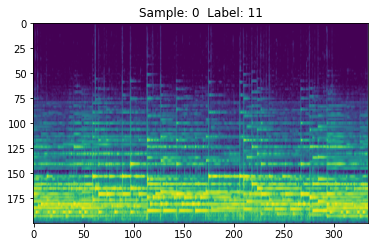

In [ ]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the lots of values to a 423x288 image
    image = train_images[num].reshape([IMG_HEIGHT, IMG_WIDTH])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image) #, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(0)

In [ ]:
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
# feature layers
feat_input = keras.Input(shape=(feat_train_values.shape[1],), name='feat_input')
x = keras.layers.Dense(512, activation='relu')(feat_input)
x = keras.layers.Dense(256, activation='relu')(x)
feat_layers = keras.layers.Dense(128, activation='relu')(x)

# image convolutional layers
img_input = keras.Input(shape=INPUT_SHAPE, name="img_input")
x = tf.cast(img_input, tf.float32)
x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(3, kernel_size=(1, 1), activation='relu')(x)
x = tf.keras.applications.Xception(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights="imagenet")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
img_layers = keras.layers.Dropout(0.25)(x)

# concatenate img layers with feature layers and define output layer
combined = keras.layers.concatenate([img_layers, feat_layers])
out_layer = keras.layers.Dense(32, activation='sigmoid')(combined)

# define model with both image and feature inputs
model = keras.Model(inputs=[feat_input, img_input], outputs=out_layer)

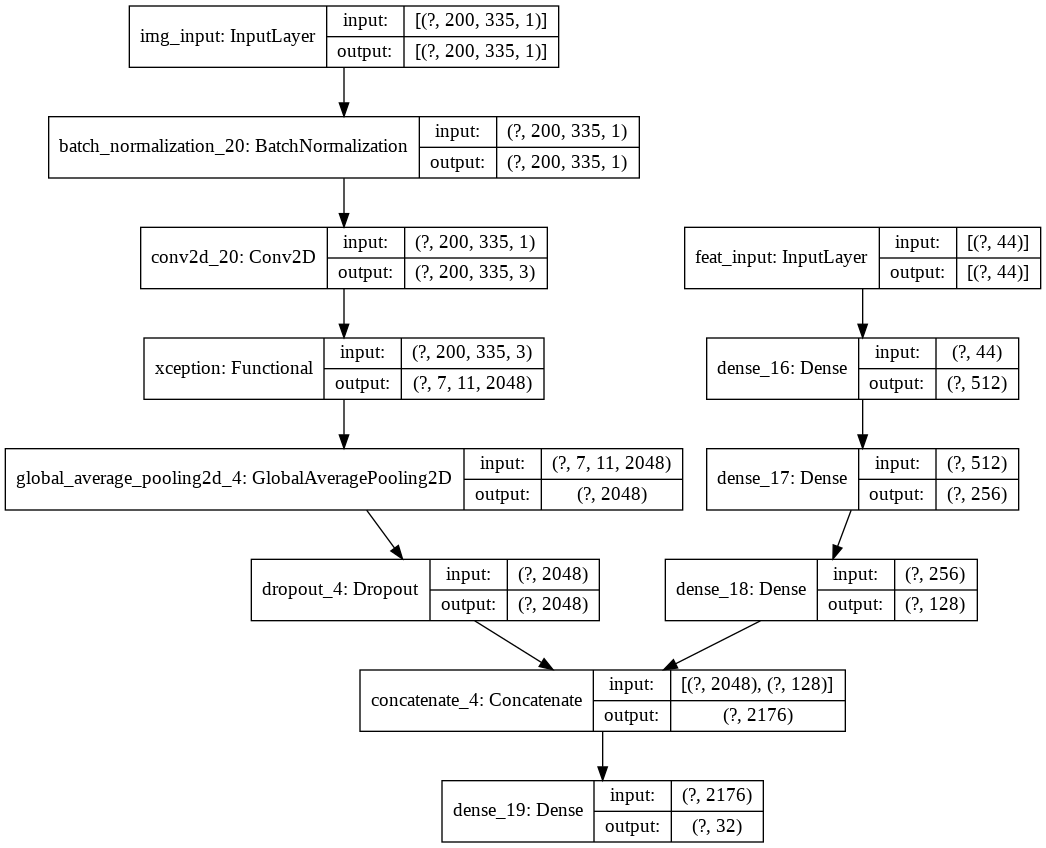

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 200, 335, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 200, 335, 1)  4           img_input[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 200, 335, 3)  6           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
feat_input (InputLayer)         [(None, 44)]         0                                            
_______________________________________________________________________________________

In [ ]:
  print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
  print(feat_train_values.shape, feat_train_labels.shape, feat_test_values.shape, feat_test_labels.shape)

(48422, 200, 335, 1) (48422, 32) (12106, 200, 335, 1) (12106, 32)
(48422, 44) (48422, 32) (12106, 44) (12106, 32)


In [ ]:
# compile model
model.compile(optimizer='adam',
          loss=keras.losses.binary_crossentropy,
          metrics=['accuracy'])

# train model
BATCH_SIZE = 32 
NUM_EPOCHS = 5 

In [ ]:
# fit model
history = model.fit(x=[feat_train_values, train_images], y=train_labels, 
                    validation_data=([feat_test_values, test_images], test_labels), 
                    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS) 

Epoch 1/5
1514/1514 [==============================] - 847s 559ms/step - loss: 0.1446 - accuracy: 0.4151 - val_loss: 0.1424 - val_accuracy: 0.4281
Epoch 2/5
1514/1514 [==============================] - 847s 559ms/step - loss: 0.1341 - accuracy: 0.4492 - val_loss: 0.1426 - val_accuracy: 0.4107
Epoch 3/5
1514/1514 [==============================] - 846s 559ms/step - loss: 0.1291 - accuracy: 0.4654 - val_loss: 0.1379 - val_accuracy: 0.4107
Epoch 4/5
1514/1514 [==============================] - 846s 559ms/step - loss: 0.1242 - accuracy: 0.4753 - val_loss: 0.1339 - val_accuracy: 0.4594
Epoch 5/5
1514/1514 [==============================] - 845s 558ms/step - loss: 0.1178 - accuracy: 0.4990 - val_loss: 0.1397 - val_accuracy: 0.4494


379/379 - 37s - loss: 0.1397 - accuracy: 0.4494


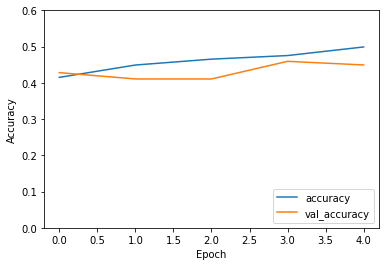

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, .6])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate([feat_test_values, test_images], test_labels, verbose=2)

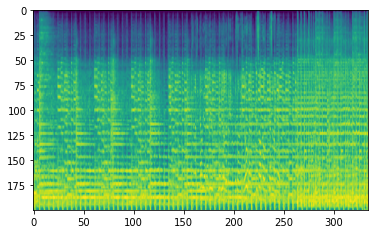

In [ ]:
# test = model.predict(test_images[0].reshape([img_height, img_width]))
num = 4321
test = test_images[num].reshape([IMG_HEIGHT, IMG_WIDTH])
plt.imshow(test)
plt.show()

In [ ]:
prediction = model.predict([np.array([feat_test_values[num]]), np.array([test_images[num]])])
prediction

array([[2.3709836e-03, 1.4666509e-04, 1.8584881e-04, 8.8518073e-06,
        1.9001097e-03, 3.4550628e-01, 3.5986504e-01, 4.4124275e-03,
        9.4074622e-04, 2.0697301e-02, 2.5260659e-02, 2.9389479e-03,
        8.2736684e-04, 5.7943833e-08, 8.9110038e-04, 3.9533421e-01,
        3.2424387e-03, 8.6796805e-02, 3.0099231e-04, 6.5212397e-08,
        8.4310136e-04, 2.3565968e-04, 1.5808547e-01, 1.8323576e-01,
        1.0204005e-07, 5.6329666e-04, 6.4472598e-04, 7.9293197e-05,
        6.1843857e-05, 4.7389083e-05, 1.4956025e-03, 7.8827789e-04]],
      dtype=float32)

In [ ]:
# top 3 predictions
top3 = np.argsort(-prediction[0])[:5]
for i, val in enumerate(top3, start=1):
  print('#{}: {}'.format(i, labels_key[val]))

#1: Punk
#2: Rock
#3: Pop
#4: Garage
#5: Indie-Rock


In [ ]:
# actual label
# print(labels[test_labels[img_num]])
print(test_labels[num])
for i, v in enumerate(test_labels[num]):
  if v == 1:
    print(labels_key[i])


[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Rock


In [ ]:
# model.save('./FMA_model.h5')